In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os import path
import time 
from datetime import datetime 
import math

In [2]:
data_dir = path.join('..', 'data')
img_dir = path.join(data_dir, 'img')

dataset_file = 'reddit_wsb.csv'

In [3]:
data = pd.read_csv(path.join(data_dir, dataset_file))
data = data.sort_values(by=['timestamp'])

## Empty body

In [4]:
data['body'] = data['body'].astype(str)
data['body'] = np.where(data['body'] == "nan", "", data['body'])

emptyCount = sum(data['body'] == "")
rowsCount  = data.shape[0]

print("Total rows",       rowsCount)
print("Empty body count", emptyCount)
print("Empty body ratio", np.around(emptyCount / rowsCount, 3))

Total rows 37155
Empty body count 18437
Empty body ratio 0.496


## Non-empty body

In [5]:
from statistics import *
bodyLensNoZero  = list(filter(lambda x: x != 0, data['body'].apply(len).tolist()))
print("Count:",   len(bodyLensNoZero))
print("Min len:", min(bodyLensNoZero))
print("Max len:", max(bodyLensNoZero))
print("Avg:",     np.around(mean(bodyLensNoZero), 2))
print("Median:",  median(bodyLensNoZero))

Count: 18718
Min len: 1
Max len: 34984
Avg: 889.18
Median: 279.0


## Most common words

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/stwasik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def tokenize(text):
    text = str(text)
    stopwords_list = stopwords.words('english')
    ret = [word for word in word_tokenize(text.lower()) if word.isalpha() and word not in stopwords_list]
    return list(set(ret))

In [9]:
def tokenize_title_body(df):
    df['title_tokens'] = df.apply(lambda x: tokenize(x['title']), axis=1)
    df['body_tokens']  = df.apply(lambda x: tokenize(x['body']), axis=1)

In [10]:
tokenize_title_body(data)

In [11]:
import numpy as np

def most_frequent_words(df_col, n=25):
    words = list(np.concatenate(df_col.values).flat)
    return dict(nltk.FreqDist(words).most_common(n))

In [12]:
def plot_most_frequent_words(words_count):
    
    sns.set(rc={'figure.figsize':(12,6)})
    ax = sns.barplot(x=list(words_count.keys()), y=list(words_count.values()))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
    plt.tight_layout()
    plt.show()

Title


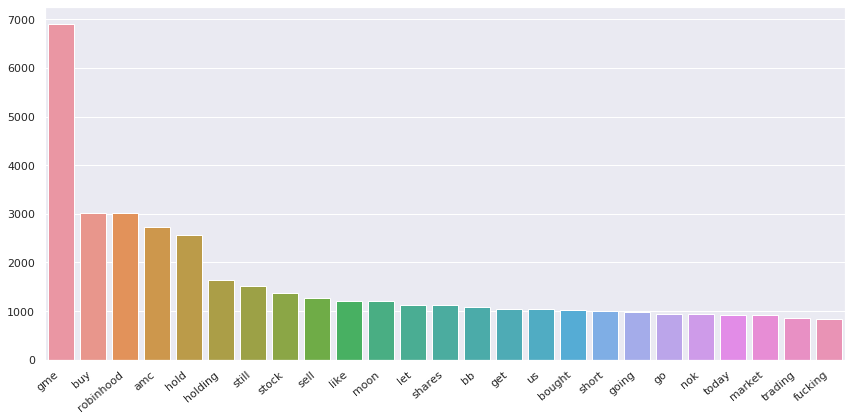

Body


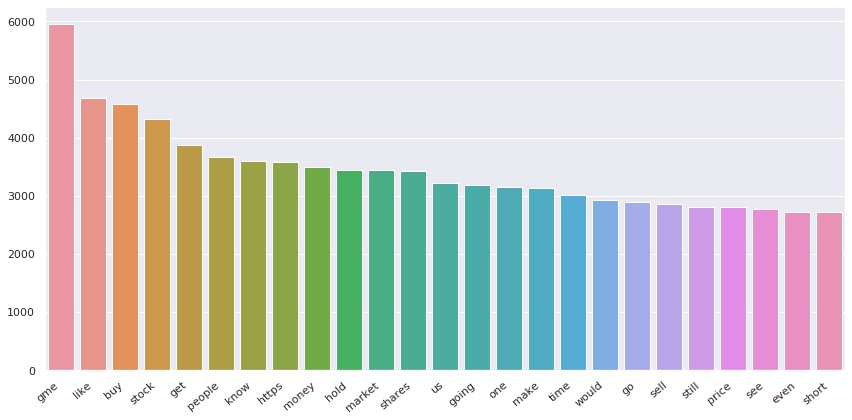

In [13]:
print("Title")
plot_most_frequent_words(most_frequent_words(data['title_tokens']))
print("Body")
plot_most_frequent_words(most_frequent_words(data['body_tokens']))

## Capital letters count

In [14]:
def count_capital_letters(text):
    text = str(text)
    return sum([1 for char in text if 91 > ord(char) > 64])

In [15]:
def capital_letters_ratio(text):
    text = str(text)
    alphacount = sum([1 for char in text if str(char).isalpha()])
    if alphacount == 0:
        return 0
    return count_capital_letters(text) / alphacount 

In [16]:
data['title_capital_letters_count'] = data.apply(lambda x: count_capital_letters(x['title']), axis=1) 
data['title_capital_letters_ratio'] = data.apply(lambda x: capital_letters_ratio(x['title']), axis=1).apply(lambda x: np.around(x, 3))
data[['title', 'title_capital_letters_count', 'title_capital_letters_ratio']]

,title,title_capital_letters_count,title_capital_letters_ratio
32591,$CBAT $SUNW $SPI $OXBR Y'all are missing the p...,16,0.432
257,An autists journey. $150 to $68k in one month....,2,0.047
256,You all have made Melvin live up to its name,2,0.057
255,I got in late on GME but I believe in the caus...,5,0.085
254,Highest SI % of Float End of Business Jan 27th...,10,0.185
...,...,...,...
36366,Absolute Hidden GEM $DVN.CN.... 💎💎💎,10,0.455
36365,30k in F calls expiring Friday. The new DFV is...,6,0.158
36364,What did one cunt say to the other cunt?,1,0.032
36363,Can I use my 401k from Charles Schwab to inves...,4,0.091


In [17]:
data['body_capital_letters_count'] = data.apply(lambda x: count_capital_letters(x['body']), axis=1) 
data['body_capital_letters_ratio'] = data.apply(lambda x: capital_letters_ratio(x['body']), axis=1).apply(lambda x: np.around(x, 3))
data[['body', 'body_capital_letters_count', 'body_capital_letters_ratio']]

,body,body_capital_letters_count,body_capital_letters_ratio
32591,$CBAT is going to be a great play further yet:...,24,0.048
257,,0,0.000
256,,0,0.000
255,You guys are amazing. Thank you for sending GM...,19,0.092
254,Will Update Daily At Market Close\n\nTop 5 sec...,78,0.561
...,...,...,...
36366,Some further DD on this absolute hidden gem $D...,177,0.090
36365,,0,0.000
36364,So I’ve been pretty much a student to this WSB...,40,0.055
36363,Would I have to pull it out or choose an optio...,5,0.023


## URLs in body

In [18]:
import re

RE_HTTP = re.compile("http(s)?://[/\.A-z0-9]+")

def detect_urls(text):
    text = str(text)

    return [str(x[1].group(0)) for x in enumerate(re.finditer(RE_HTTP, text))]

In [19]:
data['body_url'] = data.apply(lambda x: detect_urls(x['body']), axis=1) 
data['body_urls_count'] = data['body_url'].apply(len)

In [20]:
data[['body', 'body_url', 'body_urls_count']].loc[data['body_urls_count'] > 0]

,body,body_url,body_urls_count
32591,$CBAT is going to be a great play further yet:...,[https://i.imgur.com/QF4i3h8.png],1
236,"I might not be able to read letters, but numbe...","[https://www.marketwatch.com/story/gamestop, h...",4
228,https://youtu.be/cRNypdYQoWk ELON MUSK SPEAKS ...,[https://youtu.be/cRNypdYQoWk],1
227,Hedge Fund Manipulation (BlackBerry) \n\nJim C...,"[https://youtu.be/vbEEdMFrW9w, https://youtu.b...",2
215,"So, media have been blaming us retards for wha...",[https://www.investopedia.com/terms/n/nakedsho...,1
...,...,...,...
36402,"As we have all seen, everyone's least favorite...","[https://preview.redd.it/u9lfepw2kjk61.png, ht...",4
36395,What is RBLX? \n\nRoblox is a free to play gam...,"[https://backlinko.com/roblox, https://www.bus...",4
36381,&#x200B;\n\nhttps://preview.redd.it/6t4hfqquxj...,[https://preview.redd.it/6t4hfqquxjk61.png],1
36378,So in addition to being a Palantard and a prou...,[https://imgur.com/gallery/IFFMW7L],1


## Emoji

In [21]:
# pip install emoji --upgrade

In [22]:
from emoji import UNICODE_EMOJI

EMOJIS = set(UNICODE_EMOJI['en'].keys())

In [23]:
def filter_emojis(text):
    text = str(text)
    res = []
    for word in text.split(' '):
        for char in word:
            if char in EMOJIS:
                res.append(char)
                
    return res

In [24]:
def emojis_ratio(df_origin, df_emojis):
    x = df_origin.apply(len)
    x = np.where(x == 0, 1, x)
    return (df_emojis.apply(len) / x).apply(lambda x: np.around(x, 3))

### Emoji (title)

In [25]:
data['title_emojis'] = data.apply(lambda x: filter_emojis(x['title']), axis=1)
data['title_emoji_count'] = data['title_emojis'].apply(len)
data['title_emojis_ratio'] = emojis_ratio(data['title'], data['title_emojis'])

In [26]:
data[['title', 'title_emojis', 'title_emoji_count', 'title_emojis_ratio']].loc[data['title_emoji_count'] > 0]

,title,title_emojis,title_emoji_count,title_emojis_ratio
249,Hmmmmmm turns out BlackRock is making use of o...,"[✈, ✈, ✈]",3,0.041
243,Gain porn/ GME🚀 NOK🚀 BB🚀,"[🚀, 🚀, 🚀]",3,0.125
242,So this is the TOP POST of ALL TIME ! 💫,[💫],1,0.026
241,Back Story: Uni gave me 14 days to withdraw De...,[🚀],1,0.003
233,Alright u crazy bastards I'm in. I've never bo...,"[🚀, 🚀, 🚀]",3,0.029
...,...,...,...,...
36409,just your average fellow ape who hold 7000 AMC...,"[🚀, 🚀, 🚀]",3,0.023
36392,Banana futures 🍌,[🍌],1,0.062
36386,UWMC baby!! To the moon 🌙 💦💦,"[🌙, 💦, 💦]",3,0.107
36380,AAL 🚀🌕 Spring Break Travel Heating Up - Herd I...,"[🚀, 🌕]",2,0.034


### Emoji (body)

In [27]:
data['body_emojis'] = data.apply(lambda x: filter_emojis(x['body']), axis=1)
data['body_emoji_count'] = data['body_emojis'].apply(len)
data['body_emojis_ratio'] = emojis_ratio(data['body'], data['body_emojis'])

In [28]:
data[['body', 'body_emojis', 'body_emoji_count', 'body_emojis_ratio']].loc[data['body_emojis_ratio'] > 0]

,body,body_emojis,body_emoji_count,body_emojis_ratio
255,You guys are amazing. Thank you for sending GM...,[🚀],1,0.004
236,"I might not be able to read letters, but numbe...","[🚀, 💎, 🙌, 🌙]",4,0.002
234,All the current options are deep ITM. Will thi...,"[🚀, 🚀, 🚀, 🚀, 🚀]",5,0.024
227,Hedge Fund Manipulation (BlackBerry) \n\nJim C...,"[🚀, 🚀, 🚀, 🌙]",4,0.007
223,"Guys, they are trying to divide and conquer u...","[✊, 🚀, 🚀, 🚀, 🌛]",5,0.009
...,...,...,...,...
36395,What is RBLX? \n\nRoblox is a free to play gam...,"[🚀, 🚀, 🚀, 🚀, 🚀]",5,0.002
36392,"As a long term investor, i like to stay ten st...","[🦍, 🦍, 🦍, 🦍, 🦍]",5,0.005
36391,"First let me just say, HOLY SHIT. What a fucki...","[🌈, 🐻, 💎, ✋]",4,0.004
36378,So in addition to being a Palantard and a prou...,"[💎, 🙌, 💪, 🏽, 🦍, 🚀]",6,0.001
